# Intro

This notebook gives the design decision made to decide on the sizing of the single port SRAM cell

# Setup

## Imports

In [1]:
import os
from os.path import realpath
from typing import Optional, overload

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
import ipywidgets as widgets

import numpy as np
from textwrap import dedent
import matplotlib.pyplot as plt

from pdkmaster.design import library as _lbry
from c4m.pdk import sky130
prims = sky130.tech.primitives


## Setup PySpice

Compiled libraries for ngspice 36 are provided compiled for either CentOS 7 or Ubuntu20.04 so simulation can be performed without needing to install ngspice. One can comment out the setting of the `NGPSICE_LIBRARY_PATH` environment variable and then ngspice executable in the path will be used to find the shared library. When using own ngspice it is adviced to use version 35 or later to speed up the 
Also the provided `.spiceinit` file in the running directory is needed to get this speed up.

In [2]:
import os
from os.path import realpath
_pwd = realpath(os.curdir)
_libngspice_path = f"{_pwd}/libngspice36_u2004.so"
# _libngspice_path = f"{_pwd}/libngspice36_centos7.so"
os.environ["NGSPICE_LIBRARY_PATH"] = str(_libngspice_path)

# Simulations

In [31]:
block_cell = sky130.memlib.cells["SP6TBlock_512x64_8WE"]
ckt = sky130.pyspicefab.new_pyspicecircuit(
    corner="logic_tt", top=block_cell.circuit, title="SRAM Block TB", gnd="vss",
)
vdd = 1.8
ckt.V("vdd", "vdd", ckt.gnd, vdd)
for sig in (
    *(f"a[{a_bit}]" for a_bit in range(9)),
    "clk",
    *(f"d[{word_bit}]" for word_bit in range(8)),
    *(f"q[{word_bit}]" for word_bit in range(8)),
    "we[0]",
):
    ckt.V(sig, sig, ckt.gnd, 0.0)

sim = ckt.simulator()
# Unfortunately ngspice does not seem to be up to the task to simulate such a big
# SRAM cell. Operating point simulation was stopped after more than 15 hours.
# Disable it for now.
# op = sim.operating_point()

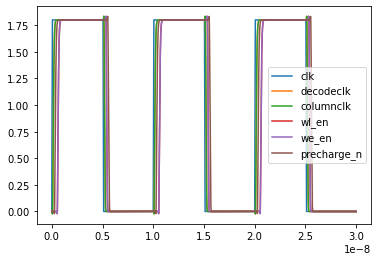

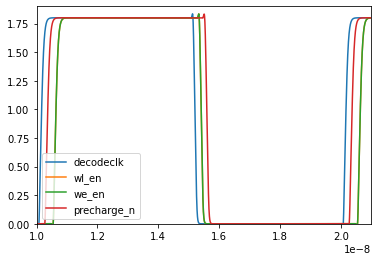

In [32]:
def _block():
    clkgen_cell = sky130.memlib.cells["SP6TClockGenerator"]
    ckt = sky130.pyspicefab.new_pyspicecircuit(
        corner="logic_tt", top=clkgen_cell.circuit, title="SRAM Block TB", gnd="vss",
    )
    vdd = 1.8
    ckt.V("vdd", "vdd", ckt.gnd, vdd)
    ckt.PulseVoltageSource(
        "clk", "clk", ckt.gnd,
        initial_value=0.0, pulsed_value=vdd,
        pulse_width=5e-9, period=10e-9, rise_time=50e-12, fall_time=50e-12,
    )
    ckt.C("precharge_n", "precharge_n", ckt.gnd, 0.1e-12)
    ckt.C("wl_en", "wl_en", ckt.gnd, 0.1e-12)
    ckt.C("we_en", "we_en", ckt.gnd, 0.1e-12)
    ckt.C("decodeclk", "decodeclk", ckt.gnd, 0.1e-12)
    ckt.C("columnclk", "columnclk", ckt.gnd, 0.1e-12)

    sim = ckt.simulator()
    trans = sim.transient(step_time=1e-12, end_time=30e-9)

    plt.figure()
    sigs = ("clk", "decodeclk", "columnclk", "wl_en", "we_en", "precharge_n")
    plt.plot(hold="on")
    for sig in sigs:
        plt.plot(trans.time, getattr(trans, sig))
    plt.legend(sigs)

    plt.figure()
    sigs = ("decodeclk", "wl_en", "we_en", "precharge_n")
    plt.plot(hold="on")
    for sig in sigs:
        plt.plot(trans.time, getattr(trans, sig))
    plt.axis([10e-9, 21e-9, 0.0, 1.9])
    plt.legend(sigs)
    plt.show()

    return trans
trans = _block()